# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [11]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import yaml

from mrcnn.config import Config
#import utils
from mrcnn import model as modellib,utils
from mrcnn import visualize
import yaml
from mrcnn.model import log
from PIL import Image
# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
#sys.path.append(ROOT_DIR)  # To find local version of the library

%matplotlib inline 

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Root directory of the project
ROOT_DIR = os.getcwd()

#ROOT_DIR = os.path.abspath("../")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

iter_num=0

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [12]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + ears

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8*6, 16*6, 32*6, 64*6, 128*6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50
    
    # Accoring to CSDN 79140840 defin a global val iter_num
    # iter_num = 0
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [13]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [14]:
# Define your own train class
class DrugDataset(utils.Dataset):
    # 得到该图中有多少个实例（物体）
    def get_obj_index(self, image):
        n = np.max(image)
        return n

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read())
            labels = temp['label_names']
            del labels[0]
        return labels

    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image,image_id):
        #print("draw_mask-->",image_id)
        #print("self.image_info",self.image_info)
        info = self.image_info[image_id]
        #print("info-->",info)
        #print("info[width]----->",info['width'],"-info[height]--->",info['height'])
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    #print("image_id-->",image_id,"-i--->",i,"-j--->",j)
                    #print("info[width]----->",info['width'],"-info[height]--->",info['height'])
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask

    # 重新写load_shapes，里面包含自己的自己的类别
    # 并在self.image_info信息中添加了path、mask_path 、yaml_path
    # yaml_pathdataset_root_path = "/tongue_dateset/"
    # img_floder = dataset_root_path + "rgb"
    # mask_floder = dataset_root_path + "mask"
    # dataset_root_path = "/tongue_dateset/"
    def load_shapes(self, count, img_floder, mask_floder, imglist, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "tank") # ears

        for i in range(count):
            # 获取图片宽和高

            filestr = imglist[i].split(".")[0]
            #print(imglist[i],"-->",cv_img.shape[1],"--->",cv_img.shape[0])
            #print("id-->", i, " imglist[", i, "]-->", imglist[i],"filestr-->",filestr)
            # filestr = filestr.split("_")[1]
            mask_path = mask_floder + "/" + filestr + ".png"
            yaml_path = dataset_root_path + "labelme_json/" + filestr + "_json/info.yaml"
            print(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")
            cv_img = cv2.imread(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")

            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                           width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)

    # 重写load_mask
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        print("image_id",image_id)
        info = self.image_info[image_id]
        count = 1  # number of object
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img,image_id)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion

            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels = []
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("tank") != -1:
                # print "box"
                labels_form.append("tank")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax
        



In [15]:
#基础设置
dataset_root_path="train_data/"
img_floder = dataset_root_path + "pic"
mask_floder = dataset_root_path + "cv2_mask"
#yaml_floder = dataset_root_path
imglist = os.listdir(img_floder)
count = len(imglist)

In [16]:
#train与val数据集准备
dataset_train = DrugDataset()
dataset_train.load_shapes(count, img_floder, mask_floder, imglist,dataset_root_path)
dataset_train.prepare()
#print("dataset_train-->",dataset_train._image_ids)

dataset_val = DrugDataset()
dataset_val.load_shapes(7, img_floder, mask_floder, imglist,dataset_root_path)
dataset_val.prepare()

train_data/labelme_json/49_json/img.png
train_data/labelme_json/28_json/img.png
train_data/labelme_json/23_json/img.png
train_data/labelme_json/2_json/img.png
train_data/labelme_json/24_json/img.png
train_data/labelme_json/20_json/img.png
train_data/labelme_json/38_json/img.png
train_data/labelme_json/40_json/img.png
train_data/labelme_json/19_json/img.png
train_data/labelme_json/3_json/img.png
train_data/labelme_json/9_json/img.png
train_data/labelme_json/14_json/img.png
train_data/labelme_json/41_json/img.png
train_data/labelme_json/12_json/img.png
train_data/labelme_json/44_json/img.png
train_data/labelme_json/5_json/img.png
train_data/labelme_json/55_json/img.png
train_data/labelme_json/56_json/img.png
train_data/labelme_json/29_json/img.png
train_data/labelme_json/1_json/img.png
train_data/labelme_json/17_json/img.png
train_data/labelme_json/33_json/img.png
train_data/labelme_json/18_json/img.png
train_data/labelme_json/35_json/img.png
train_data/labelme_json/43_json/img.png
train

image_id 49


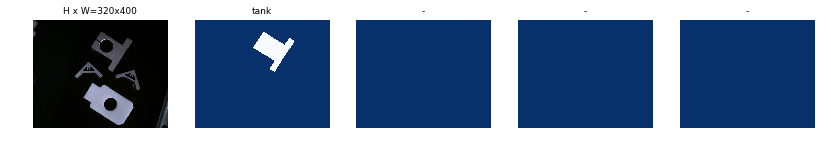

image_id 38


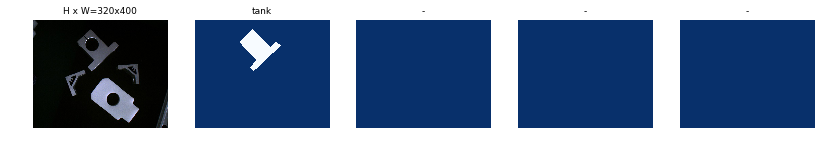

image_id 49


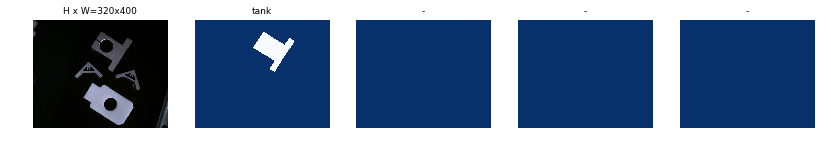

image_id 6


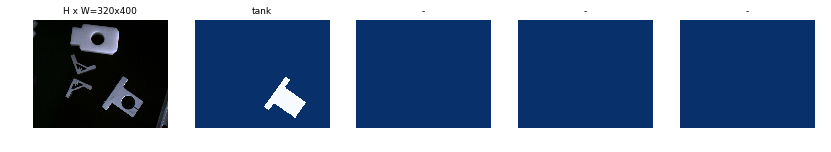

In [17]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [18]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/wangle/Mask_RCNN/logs/shapes20190118T1609/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mas

/home/wangle/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wangle/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
image_id 52
image_id 52
image_id 52
image_id 52
image_id 3
image_id 52
image_id 52
image_id 3
image_id 52
image_id 52
image_id 3
image_id 52
image_id 3
image_id 3
image_id 3
image_id 52
image_id 52
image_id 3
image_id 3
image_id 3
image_id 3
image_id 52
image_id 3
image_id 3
image_id 10
image_id 10
image_id 10
image_id 0
image_id 0
image_id 10
image_id 10
image_id 10
image_id 0
image_id 10
image_id 0
image_id 10
image_id 10
image_id 0
image_id 10
image_id 0
image_id 10
image_id 0
image_id 0
image_id 10
image_id 0
image_id 0
image_id 0
image_id 0
image_id 2
image_id 19
image_id 2
image_id 19
image_id 19
image_id 19
image_id 2
image_id 19
image_id 19
image_id 19
image_id 19
image_id 19
image_id 19
image_id 2
image_id 19
image_id 19
image_id 2
image_id 2
image_id 2
image_id 2
image_id 2
image_id 2
image_id 2
image_id 2
image_id 5
image_id 5
image_id 31
image_id 31
image_id 31
image_id 5
image_id 31
image_id 31
image_id 31
image_id 31
image_id 31
image_id 31
image_id 31
image_id

 99/100 [============================>.] - ETA: 8s - loss: 0.6400 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.2287 - mrcnn_mask_loss: 0.2122 image_id 35
image_id 1
image_id 1
image_id 1
image_id 1
image_id 4
image_id 1
image_id 5
image_id 1
image_id 3
image_id 1
image_id 5
image_id 3
image_id 3
image_id 3
image_id 3
image_id 3
image_id 1
image_id 3
image_id 6
image_id 3
image_id 5
image_id 3
image_id 6
image_id 5
image_id 5
image_id 5
image_id 5
image_id 5
image_id 3
image_id 5
image_id 2
image_id 5
image_id 6
image_id 5
image_id 2
image_id 6
image_id 6
image_id 6
image_id 6
image_id 6
image_id 5
image_id 6
image_id 0
image_id 6
image_id 2
image_id 6
image_id 0
image_id 2
image_id 2
image_id 2
100/100 [==============================] - 957s 10s/step - loss: 0.6371 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.2271 - mrcnn_mask_loss: 0.2110 - val_loss: 0.6327 - val_rpn_class_loss: 0.0

 99/100 [============================>.] - ETA: 8s - loss: 0.4425 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.1013 image_id 13
image_id 2
image_id 2
image_id 6
image_id 2
image_id 0
image_id 2
image_id 0
image_id 2
image_id 0
image_id 0
image_id 0
image_id 0
image_id 0
image_id 0
image_id 2
image_id 0
image_id 2
image_id 0
image_id 0
image_id 0
image_id 2
image_id 0
image_id 0
image_id 0
image_id 0
image_id 0
image_id 0
image_id 0
image_id 4
image_id 0
image_id 2
image_id 0
image_id 4
image_id 2
image_id 2
image_id 2
image_id 2
image_id 2
image_id 0
image_id 2
image_id 5
image_id 2
image_id 4
image_id 2
image_id 5
image_id 4
image_id 4
image_id 4
image_id 4
image_id 4
100/100 [==============================] - 943s 9s/step - loss: 0.4402 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.1008 - val_loss: 0.5344 - val_rpn_class_loss: 0.00

 95/100 [===========================>..] - ETA: 42s - loss: 0.2959 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.0756image_id 0


 99/100 [============================>.] - ETA: 8s - loss: 0.2903 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.0748 image_id 0
image_id 2
image_id 4
image_id 6
image_id 4
image_id 5
image_id 4
image_id 6
image_id 5
image_id 5
image_id 5
image_id 5
image_id 5
image_id 4
image_id 5
image_id 3
image_id 5
image_id 6
image_id 5
image_id 3
image_id 6
image_id 6
image_id 6
image_id 6
image_id 6
image_id 5
image_id 6
image_id 1
image_id 6
image_id 3
image_id 6
image_id 1
image_id 3
image_id 3
image_id 3
image_id 3
image_id 3
image_id 6
image_id 3
image_id 5
image_id 3
image_id 1
image_id 3
image_id 5
image_id 1
image_id 1
image_id 1
image_id 1
image_id 1
image_id 3
image_id 1
100/100 [==============================] - 941s 9s/step - loss: 0.2916 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.0753 - val_loss: 0.4635 - val_rpn_class_loss: 0.003

 34/100 [=========>....................] - ETA: 9:28 - loss: 0.2504 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.0736image_id 54


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
           learning_rate=config.LEARNING_RATE / 10,
           epochs=30,
           layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/wangle/Mask_RCNN/logs/shapes20190107T1220/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bra

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [10]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)


# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/wangle/Mask_RCNN/logs/shapes20190117T0951/mask_rcnn_shapes_0003.h5
Re-starting from epoch 3


Processing 1 images
image                    shape: (640, 480, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 36828, 4)         min:   -1.41791  max:    2.25080  float32
shijian 18


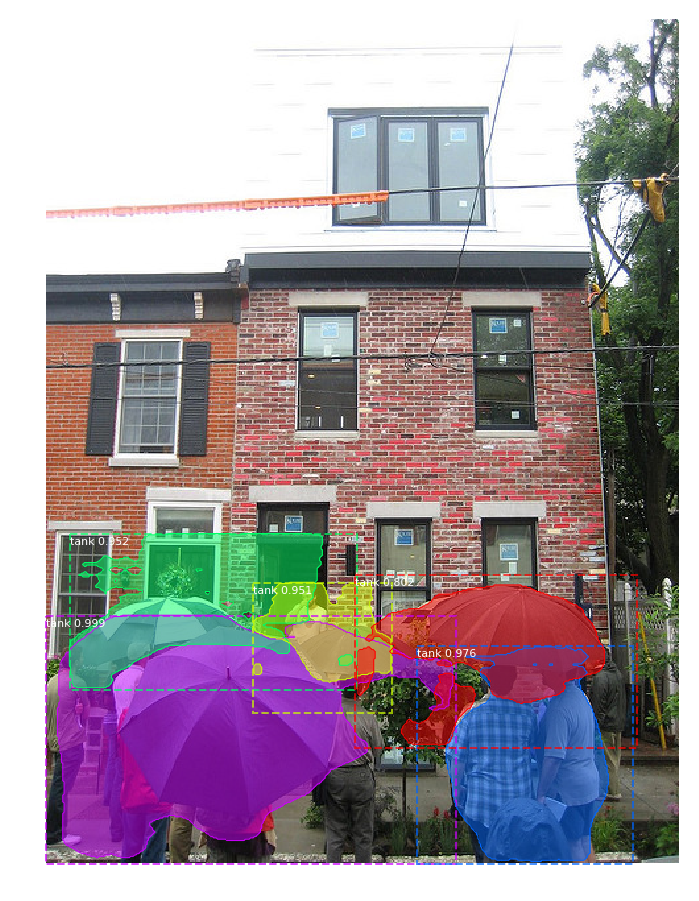

In [14]:
#get from test_model.py
import skimage.io
from datetime import datetime 
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'ears']
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

a=datetime.now() 
# Run detection
results = model.detect([image], verbose=1)
b=datetime.now() 
# Visualize results
print("shijian",(b-a).seconds)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

image_id 0
original_image           shape: (384, 384, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  400.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   59.00000  max:  237.00000  int32
gt_mask                  shape: (384, 384, 1)         min:    0.00000  max:    1.00000  uint8


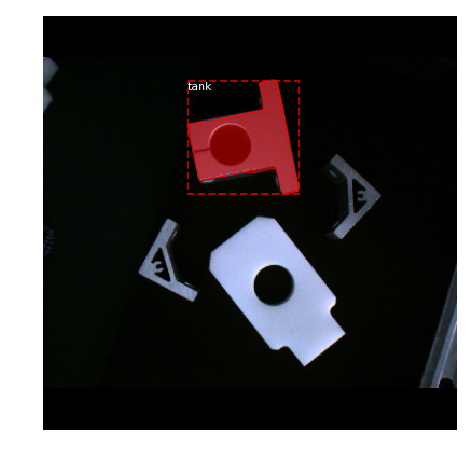

In [17]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))


Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 36828, 4)         min:   -1.41791  max:    2.25080  float32


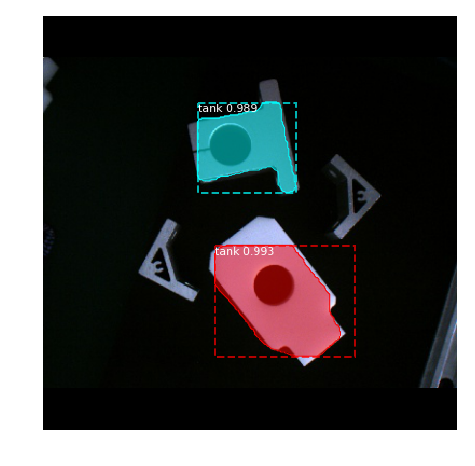

In [18]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [19]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

image_id 6
image_id 5
image_id 0
image_id 5
image_id 0
image_id 3
image_id 5
image_id 6
image_id 1
image_id 0
mAP:  0.85
